In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv').sort_values(['series_id', 'measurement_number'])

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner').sort_values(['series_id', 'measurement_number'])
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Feature engineering

In [4]:
def feat_eng(df):
    df['totl_anglr_vel'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z'])** 0.5
    df['totl_linr_acc'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z'])**0.5
    df['totl_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z'])**0.5
    df['acc_vs_vel'] = df['totl_linr_acc'] / df['totl_anglr_vel']

feat_eng(train)
feat_eng(test)

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [5]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z


def perform_feature_engineering(df):
    x, y, z, w = df['orientation_X'].tolist(), df['orientation_Y'].tolist(), df['orientation_Z'].tolist(), df['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    df['euler_x'] = nx
    df['euler_y'] = ny
    df['euler_z'] = nz
    
    df['total_angle'] = np.sqrt(np.square(df['euler_x']) + np.square(df['euler_y']) + np.square(df['euler_z']))
    df['angle_vs_acc'] = df['total_angle'] / df['totl_linr_acc']
    df['angle_vs_vel'] = df['total_angle'] / df['totl_anglr_vel']
    
perform_feature_engineering(train)
perform_feature_engineering(test)

In [6]:
def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

def mean_abs_change(x):
    return np.mean(np.abs(np.diff(x)))

def summarize_cols(df):
    cols = df.columns
    for col in cols:
        if col in ['row_id', 'series_id', 'measurement_number', 'group_id', 'surface']:
            continue
        df[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        df[col + '_min'] = df.groupby(['series_id'])[col].min()
        df[col + '_max'] = df.groupby(['series_id'])[col].max()
        df[col + '_std'] = df.groupby(['series_id'])[col].std()
#         df[col + '_mad'] = df.groupby(['series_id'])[col].mad()
#         df[col + '_med'] = df.groupby(['series_id'])[col].median()
#         df[col + '_skew'] = df.groupby(['series_id'])[col].skew()
        df[col + '_max_to_min'] = df[col + '_max'] / df[col + '_min']
#         df[col + '_mean_abs_change'] = df.groupby('series_id')[col].apply(mean_abs_change)
#         df[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
#         df[col + '_abs_max'] = df.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
#         df[col + '_abs_min'] = df.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
#         df[col + '_abs_mean'] = df.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(x)))
#         df[col + '_abs_std'] = df.groupby('series_id')[col].apply(lambda x: np.std(np.abs(x)))

old_cols = list(train.columns)
summarize_cols(train)
summarize_cols(test)
add_cols = list(set(list(train.columns)) - set(old_cols))

In [7]:
train.fillna(0, inplace = True)
train.replace(-np.inf, 0, inplace = True)
train.replace(np.inf, 0, inplace = True)
test.fillna(0, inplace = True)
test.replace(-np.inf, 0, inplace = True)
test.replace(np.inf, 0, inplace = True)

### Turn data into series

In [8]:
def series_to_supervised(data, features, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in features]
    # Current timestep (t=0)
    cols.append(data)
    names += [(col) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [9]:
window = 3
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'totl_anglr_vel', 'totl_linr_acc', 'totl_xyz', 'acc_vs_vel' ,
            'series_id'] + add_cols
use_cols = features + ['surface']
# Train
train_series = series_to_supervised(train[use_cols], features, window=window)
train_series.dropna(inplace=True)        
train_series = train_series[(train_series['series_id'] == train_series['series_id(t-%s)' % window])]
display(train_series.head())

# Test
test_series = series_to_supervised(test[features], features, window=window)
test_series.fillna(test_series.mean(), inplace=True)

# Backwards inputation
for index, row in test_series.iterrows():
    for i in range(1, window+1):
        if row['series_id'] != row['series_id(t-%s)' % i]:
            for feature in features:
                if feature != 'series_id':
                    test_series.at[index, '%s(t-%s)' % (feature, i)] = row[feature]
display(test_series.head())

,orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),totl_anglr_vel(t-3),totl_linr_acc(t-3),totl_xyz(t-3),acc_vs_vel(t-3),series_id(t-3),angular_velocity_Z_min(t-3),orientation_X_max_to_min(t-3),orientation_Y_mean(t-3),angle_vs_acc_std(t-3),acc_vs_vel_std(t-3),totl_anglr_vel_max_to_min(t-3),euler_y_max_to_min(t-3),angular_velocity_Z_std(t-3),acc_vs_vel_min(t-3),euler_y_max(t-3),angular_velocity_X_std(t-3),linear_acceleration_X_max_to_min(t-3),linear_acceleration_X_max(t-3),orientation_Z_max_to_min(t-3),linear_acceleration_Y_std(t-3),totl_linr_acc_mean(t-3),linear_acceleration_Z_mean(t-3),orientation_Z_mean(t-3),angular_velocity_Y_max(t-3),linear_acceleration_X_mean(t-3),linear_acceleration_Z_std(t-3),linear_acceleration_X_std(t-3),angular_velocity_X_mean(t-3),angular_velocity_Z_max(t-3),totl_anglr_vel_mean(t-3),...,euler_y_mean,euler_x_min,angular_velocity_Y_min,total_angle_min,orientation_X_std,angle_vs_vel_std,totl_linr_acc_max_to_min,linear_acceleration_Y_min,orientation_Y_max,totl_xyz_std,orientation_Y_std,angular_velocity_X_max_to_min,orientation_X_mean,totl_xyz_mean,acc_vs_vel_max,angle_vs_vel_mean,orientation_W_max,orientation_Z_min,totl_linr_acc_min,angle_vs_acc_max,totl_xyz_max_to_min,linear_acceleration_Z_max_to_min,euler_x_mean,linear_acceleration_Y_max,angular_velocity_Z_mean,linear_acceleration_X_min,euler_y_min,totl_linr_acc_std,euler_y_std,totl_xyz_min,orientation_Z_max,angular_velocity_Y_std,linear_acceleration_Y_max_to_min,orientation_W_mean,angular_velocity_X_max,totl_anglr_vel_std,totl_anglr_vel_min,totl_linr_acc_max,total_angle_mean,surface
3,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.112536,0.0,0.934285,0.0,0.0,-0.030181,0.998275,-0.634008,0.0,24.926122,0.0,0.913435,0.017127,0.0,-0.023562,0.052800,-1.530680,2.85380,0.985585,1.387790,1.562540,-9.320391,-0.105474,0.072698,0.263418,1.095040,0.911175,-0.002481,0.051720,0.094213,...,-0.015107,2.841356,-0.168150,2.911642,0.000227,0.0,0.0,-5.82510,0.31147,0.000062,0.000453,-1.292912,-0.939169,1.008554,113.910293,0.0,-0.139340,0.037922,0.0,0.0,1.000273,0.028173,2.845777,11.7430,0.007887,-3.79340,-0.015698,3.055175,0.000234,1.008410,0.039799,0.046700,-2.015931,-0.142319,0.519130,0.123815,0.0,11.504129,2.915945,fine_concrete
4,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.094263,0.0,0.934267,0.0,0.0,-0.121610,0.999385,0.241867,0.0,8.570933,0.0,0.754531,0.067533,0.0,-0.009109,0.092309,-1.597107,5.10020,1.060222,1.864457,1.582105,-9.388899,0.031650,0.112080,0.121867,2.123065,1.105945,0.004605,0.129150,0.140349,...,-0.009793,2.841190,0.008231,2.972552,0.002955,0.0,0.0,0.34207,0.43740,0.000478,0.006165,-0.777400,-0.891301,1.018738,0.000000,0.0,-0.135380,0.058247,0.0,0.0,1.001583,0.678724,2.842442,4.8181,-0.142385,-1.26960,-0.010192,1.320058,0.000241,1.017889,0.061771,0.016114,14.085129,-0.136460,0.080904,0.000000,0.0,3.831081,2.979806,fine_concrete
5,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.000000,0.0,0.934263,0.0,0.0,-0.015697,0.990473,-0.846171,0.0,12.823509,0.0,0.926276,0.021866,0.0,-0.011795,0.060168,-0.714732,1.85330,0.986339,1.769792,1.501716,-9.395783,-0.129371,0.091946,0.149711,1.140267,0.756138,0.002646,0.088730,0.166206,...,-0.023433,2.836705,-0.132780,3.564681,0.000315,0.0,0.0,-3.07270,-0.87206,0.000450,0.000225,-1.391009,0.464712,0.921923,529.285958,0.0,0.081804,-0.128700,0.0,0.0,1.001858,0.243404,2.839376,7.9689,-0.006881,-4.87980,-0.025019,2.144704,0.000959,0.920939,-0.126240,0.055027,-2.593452,0.081212,0.274140,0.110125,0.0,7.911122,3.567185,fine_concrete
6,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.000000,0.0,0.934246,0.0,0.0,-0.073414,0.999106,0.310140,0.0,20.158927,0.0,0.932940,0.032265,0.0,-0.014

,orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),totl_anglr_vel(t-3),totl_linr_acc(t-3),totl_xyz(t-3),acc_vs_vel(t-3),series_id(t-3),angular_velocity_Z_min(t-3),orientation_X_max_to_min(t-3),orientation_Y_mean(t-3),angle_vs_acc_std(t-3),acc_vs_vel_std(t-3),totl_anglr_vel_max_to_min(t-3),euler_y_max_to_min(t-3),angular_velocity_Z_std(t-3),acc_vs_vel_min(t-3),euler_y_max(t-3),angular_velocity_X_std(t-3),linear_acceleration_X_max_to_min(t-3),linear_acceleration_X_max(t-3),orientation_Z_max_to_min(t-3),linear_acceleration_Y_std(t-3),totl_linr_acc_mean(t-3),linear_acceleration_Z_mean(t-3),orientation_Z_mean(t-3),angular_velocity_Y_max(t-3),linear_acceleration_X_mean(t-3),linear_acceleration_Z_std(t-3),linear_acceleration_X_std(t-3),angular_velocity_X_mean(t-3),angular_velocity_Z_max(t-3),totl_anglr_vel_mean(t-3),...,angle_vs_acc_min,euler_y_mean,euler_x_min,angular_velocity_Y_min,total_angle_min,orientation_X_std,angle_vs_vel_std,totl_linr_acc_max_to_min,linear_acceleration_Y_min,orientation_Y_max,totl_xyz_std,orientation_Y_std,angular_velocity_X_max_to_min,orientation_X_mean,totl_xyz_mean,acc_vs_vel_max,angle_vs_vel_mean,orientation_W_max,orientation_Z_min,totl_linr_acc_min,angle_vs_acc_max,totl_xyz_max_to_min,linear_acceleration_Z_max_to_min,euler_x_mean,linear_acceleration_Y_max,angular_velocity_Z_mean,linear_acceleration_X_min,euler_y_min,totl_linr_acc_std,euler_y_std,totl_xyz_min,orientation_Z_max,angular_velocity_Y_std,linear_acceleration_Y_max_to_min,orientation_W_mean,angular_velocity_X_max,totl_anglr_vel_std,totl_anglr_vel_min,totl_linr_acc_max,total_angle_mean
0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,1907.488284,-0.10259,0.952230,-0.988644,0.0,12.672654,0.0,0.883538,0.050473,0.0,-0.012999,0.083389,-1.098807,3.3996,0.991662,1.169997,1.385358,-9.325264,-0.148006,0.114860,0.141545,2.267268,1.295220,0.000994,0.097635,0.107979,...,0.703315,-0.013864,2.843289,-0.137970,4.199968,0.000284,0.0,0.0,0.20204,-0.98854,0.000180,0.000039,-1.025088,-0.025810,0.911086,92.643199,0.0,0.003609,-0.148720,0.0,0.0,1.000963,0.244224,2.844735,6.3266,-0.002971,-3.09390,-0.014712,1.622136,0.000423,0.910583,-0.147480,0.042971,31.313601,0.003147,0.231270,0.116674,0.0,5.972473,4.201174
1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.0,2.898157,0.910972,0.0,1907.488284,-0.10556,0.997601,0.330271,0.0,54.688742,0.0,0.912173,0.031605,0.0,-0.011658,0.080047,-0.920209,2.2731,1.041861,1.997345,1.845927,-9.345727,0.043416,0.084099,0.022906,1.283607,0.798950,0.010602,0.037424,0.027810,...,0.495008,-0.012162,2.844010,-0.041890,2.923066,0.000564,0.0,0.0,-1.42470,0.33227,0.000143,0.001654,-2.158282,-0.932288,1.010771,608.967417,0.0,-0.139940,0.042283,0.0,0.0,1.000639,0.275330,2.845750,6.5591,-0.036900,-2.47020,-0.012780,1.829075,0.000302,1.010342,0.044053,0.027668,-4.603846,-0.140968,0.284850,0.058874,0.0,5.905764,2.925688
2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.0,0.000000,0.910904,0.0,1907.488284,-0.28306,0.981505,0.961448,0.0,12.757445,0.0,0.838630,0.092291,0.0,-0.013517,0.105865,-1.038648,6.7509,1.010797,1.721867,2.227315,-9.456413,0.144340,0.154590,0.222549,2.780109,2.342826,-0.003484,0.138020,0.120951,...,0.472371,-0.015069,2.838313,-0.161160,3.894967,0.001054,0.0,0.0,-0.92920,0.96217,0.000109,0.000260,-0.826365,-0.230186,1.059107,76.868998,0.0,-0.041394,0.143560,0.0,0.0,1.000474,0.137878,2.839936,7.9789,-0.026607,-6.49970,-0.016118,2.191927,0.000561,1.058854,0.145110,0.059318,-8.586849,-0.042394,0.250240,0.132353,0.0,8.254197,3.897528
3,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,0.000000,-0.10259,0.952230,-0.988644,0.0,12.672654,0.0,0

### Pre process the labels

In [10]:
n_labels =  train_series['surface'].nunique()
labels_names = train_series['surface'].unique()
le = LabelEncoder()
train_series['surface'] = le.fit_transform(train_series['surface'].values)

### Train/validation split

In [11]:
train_splited = []
val_splited = []
gp_surface = train.groupby(['surface', 'series_id'], as_index=False).count()[['surface', 'series_id']]
for surface in gp_surface['surface'].unique():
    df = gp_surface[gp_surface['surface'] == surface]
    tra, val = train_test_split(df, test_size=0.2, random_state=0)
    train_splited += list(tra['series_id'].values)
    val_splited += list(val['series_id'].values)
    
train_splited = pd.DataFrame(train_splited, columns=['series_id'])
val_splited = pd.DataFrame(val_splited, columns=['series_id'])

In [12]:
X_train = train_splited.merge(train_series)
X_val = val_splited.merge(train_series)

Y_train = X_train['surface']
Y_train = to_categorical(Y_train)
X_train.drop('surface', axis=1, inplace=True)
X_train = X_train

Y_val = X_val['surface']
Y_val = to_categorical(Y_val)
X_val.drop('surface', axis=1, inplace=True)
X_val = X_val

series_cols = list(X_train.filter(regex='series_id'))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (380500, 456)
Validation shape (95750, 456)


,orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),totl_anglr_vel(t-3),totl_linr_acc(t-3),totl_xyz(t-3),acc_vs_vel(t-3),angular_velocity_Z_min(t-3),orientation_X_max_to_min(t-3),orientation_Y_mean(t-3),angle_vs_acc_std(t-3),acc_vs_vel_std(t-3),totl_anglr_vel_max_to_min(t-3),euler_y_max_to_min(t-3),angular_velocity_Z_std(t-3),acc_vs_vel_min(t-3),euler_y_max(t-3),angular_velocity_X_std(t-3),linear_acceleration_X_max_to_min(t-3),linear_acceleration_X_max(t-3),orientation_Z_max_to_min(t-3),linear_acceleration_Y_std(t-3),totl_linr_acc_mean(t-3),linear_acceleration_Z_mean(t-3),orientation_Z_mean(t-3),angular_velocity_Y_max(t-3),linear_acceleration_X_mean(t-3),linear_acceleration_Z_std(t-3),linear_acceleration_X_std(t-3),angular_velocity_X_mean(t-3),angular_velocity_Z_max(t-3),totl_anglr_vel_mean(t-3),acc_vs_vel_max_to_min(t-3),...,angle_vs_acc_min,euler_y_mean,euler_x_min,angular_velocity_Y_min,total_angle_min,orientation_X_std,angle_vs_vel_std,totl_linr_acc_max_to_min,linear_acceleration_Y_min,orientation_Y_max,totl_xyz_std,orientation_Y_std,angular_velocity_X_max_to_min,orientation_X_mean,totl_xyz_mean,acc_vs_vel_max,angle_vs_vel_mean,orientation_W_max,orientation_Z_min,totl_linr_acc_min,angle_vs_acc_max,totl_xyz_max_to_min,linear_acceleration_Z_max_to_min,euler_x_mean,linear_acceleration_Y_max,angular_velocity_Z_mean,linear_acceleration_X_min,euler_y_min,totl_linr_acc_std,euler_y_std,totl_xyz_min,orientation_Z_max,angular_velocity_Y_std,linear_acceleration_Y_max_to_min,orientation_W_mean,angular_velocity_X_max,totl_anglr_vel_std,totl_anglr_vel_min,totl_linr_acc_max,total_angle_mean
0,-0.98321,0.10564,0.009016,-0.14851,0.028959,-0.011703,0.026238,0.032400,4.1378,-8.8985,0.164965,2.867741,0.993417,17.383894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.98321,0.10565,0.009034,-0.14853,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.175046,2.211620,0.993427,12.634507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.98321,0.10570,0.009057,-0.14850,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.199857,1.247219,0.993444,6.240562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.98321,0.10576,0.009086,-0.14845,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.200036,2.600838,0.993465,13.001842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.98321,0.10581,0.009083,-0.14842,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.201849,2.562021,0.993469,12.692764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature engineering

In [13]:
features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe().T)

Train shape (380500, 456)
Validation shape (95750, 456)


,count,mean,std,min,25%,50%,75%,max
orientation_X(t-3),380500.0,-0.011270,0.684463,-0.988980,-0.695612,-0.091329,0.654163,0.989100
orientation_Y(t-3),380500.0,0.087477,0.708123,-0.989650,-0.675482,0.262120,0.816970,0.988980
orientation_Z(t-3),380500.0,0.014343,0.105967,-0.159400,-0.088137,0.035826,0.124430,0.155710
orientation_W(t-3),380500.0,-0.002825,0.104182,-0.156620,-0.103450,-0.017440,0.098690,0.154770
angular_velocity_X(t-3),380500.0,0.000239,0.116873,-2.371000,-0.040808,0.000078,0.040634,2.282200
angular_velocity_Y(t-3),380500.0,0.008491,0.088018,-0.927860,-0.033364,0.005357,0.047895,1.079100
angular_velocity_Z(t-3),380500.0,-0.019517,0.226591,-1.268800,-0.090294,-0.005177,0.065491,1.387300
linear_acceleration_X(t-3),380500.0,0.128835,1.871720,-31.142000,-0.536833,0.123810,0.795283,36.797000
linear_acceleration_Y(t-3),380500.0,2.887363,2.103895,-82.753000,1.958700,2.879400,3.803100,55.948000
linear_acceleration_Z(t-3),380500.0,-9.364587,2.826003,-65.492000,-10.200000,-9.365800,-8.513100,65.839000


### Scale the data

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_series)

In [15]:
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
print('Validation set shape', X_val_series.shape)

Validation set shape (95750, 4, 114)


In [16]:
X_train_series = X_train.reshape(X_train.shape[0], (window+1), (X_train.shape[1] // (window+1)))
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
X_test_series = X_test.reshape(X_test.shape[0], (window+1), (X_test.shape[1] // (window+1)))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_val_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (380500, 4, 114)
Validation set shape (95750, 4, 114)
Test set shape (488448, 4, 114)


### Model

In [17]:
epochs = 30
batch = 128
lr = 0.0001
adam = optimizers.Adam(lr)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model.add(LSTM(8, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 16)             8384      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 81        
Total params: 9,265
Trainable params: 9,265
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train_series, Y_train, validation_data=(X_val_series, Y_val), epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 380500 samples, validate on 95750 samples
Epoch 1/30
 - 256s - loss: 1.8783 - val_loss: 1.7472
Epoch 2/30
 - 254s - loss: 1.6618 - val_loss: 1.6345
Epoch 3/30
 - 254s - loss: 1.5587 - val_loss: 1.5393
Epoch 4/30
 - 254s - loss: 1.4866 - val_loss: 1.4879
Epoch 5/30
 - 255s - loss: 1.4432 - val_loss: 1.4470
Epoch 6/30
 - 255s - loss: 1.4104 - val_loss: 1.4222
Epoch 7/30
 - 255s - loss: 1.3829 - val_loss: 1.4056
Epoch 8/30
 - 254s - loss: 1.3569 - val_loss: 1.3784
Epoch 9/30
 - 256s - loss: 1.3299 - val_loss: 1.3586
Epoch 10/30
 - 258s - loss: 1.3025 - val_loss: 1.3402
Epoch 11/30
 - 254s - loss: 1.2773 - val_loss: 1.3218
Epoch 12/30
 - 254s - loss: 1.2528 - val_loss: 1.2835
Epoch 13/30
 - 254s - loss: 1.2310 - val_loss: 1.2641
Epoch 14/30
 - 251s - loss: 1.2119 - val_loss: 1.2303
Epoch 15/30
 - 246s - loss: 1.1936 - val_loss: 1.2555
Epoch 16/30
 - 245s - loss: 1.1764 - val_loss: 1.2128
Epoch 17/30
 - 245s - loss: 1.1606 - val_loss:

#### Model loss plot

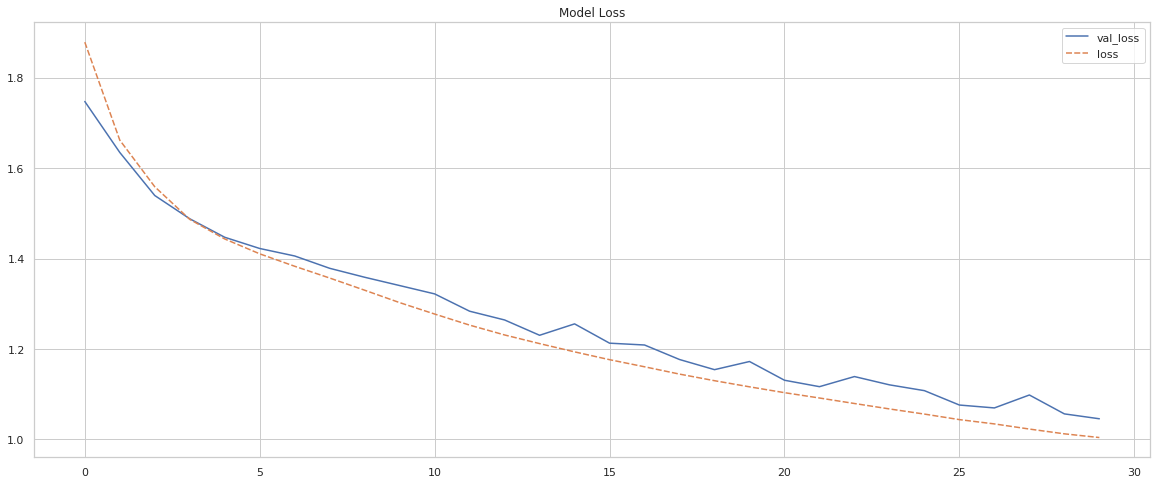

In [20]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [21]:
train_pred = model.predict_classes(X_train_series)
val_pred = model.predict_classes(X_val_series)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.636604467805519
Validation accuracy 0.6160208877284595


#### Model confusion matrix

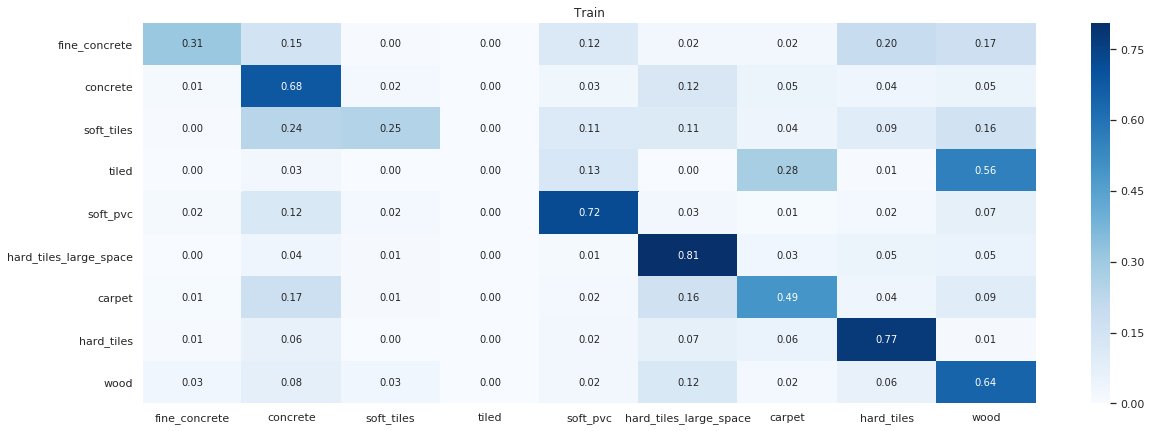

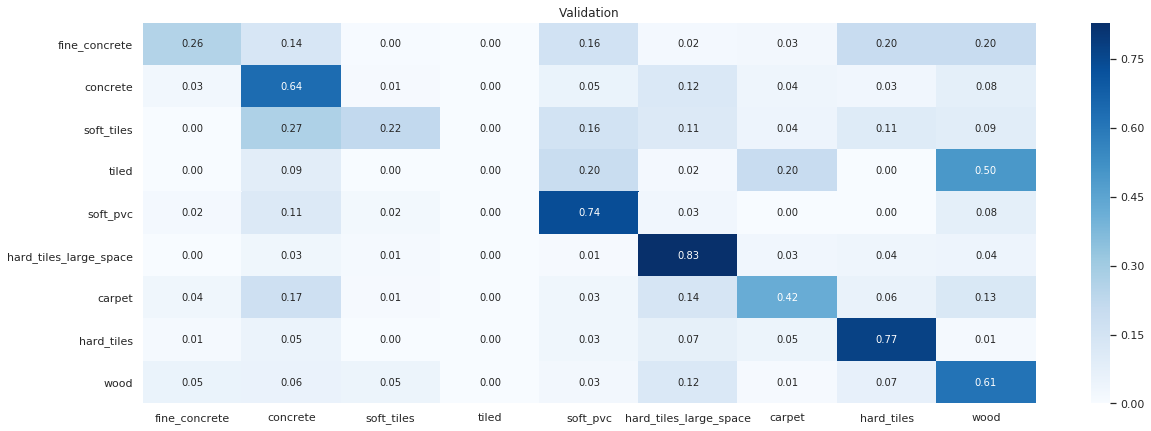

In [22]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [23]:
predictions = model.predict_classes(X_test_series)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,carpet
3,3,carpet
4,4,carpet
5,5,concrete
6,6,carpet
7,7,carpet
8,8,carpet
9,9,carpet
